# Detecting Credit Card Fraud With Autoencoder


Objective: Test autoencoder performance for fraud detection

Approach: Apply a simple model and complex model to compare against autoencoder.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from tqdm import tqdm, tqdm_notebook


df_raw = pd.read_csv("data/creditcard.csv")

## **Dataset Notes**

**Features:**

**Time:** Number of seconds elapsed between this transaction and the first transaction in the dataset

**V1-V28:** may be result of a PCA Dimensionality reduction to protect user identities and sensitive features

**Amount:** Transaction amount

**Class:** 1 for fraudulent transactions, 0 otherwise

In [2]:
from sklearn.preprocessing import StandardScaler

df = df_raw
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [3]:
y = df['Class']
X = df.drop(['Class'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

# Comparison Function

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def final_model_test(X_all, y_all, X_test, y_test, model):
    
    model.fit(X_all, y_all)
    y_pred = model.predict(X_test)
    y_true = y_test
    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()

    print("Model Results")

    print(conf)

    precision = (tp / (tp + fp))
    recall = (tp / (tp + fn))
    f1_score = 2*precision*recall/(precision + recall)

    print ('\n')
    print ("Accuracy:              %0.4f" % accuracy_score(y_pred,y_true))
    print ("Precision:              %0.4f" % precision)
    print ("Recall:                 %0.4f"% recall)
    print ("F1 Score:               %0.4f"% f1_score)


In [6]:
from sklearn.metrics import roc_curve, auc

def generate_auc(X_all, y_all, X_test, y_test, model):
    model.fit(X_all, y_all)
    y_pred = model.predict(X_test)

    y_score=model.predict_proba(X_test)[:,1]

    FPR, TPR, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(FPR, TPR)
    
    print ("AUC:               %0.4f"% roc_auc)

    # Plotting our Baseline..
    plt.plot([0,1],[0,1])
    plt.plot(FPR,TPR)
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.figure()

# Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(solver='lbfgs')
final_model_test(X_train, y_train, X_train, y_train, baseline_model)

Model Results
[[227420     31]
 [   146    248]]


Accuracy:              0.9992
Precision:              0.8889
Recall:                 0.6294
F1 Score:               0.7370


AUC:               0.9890


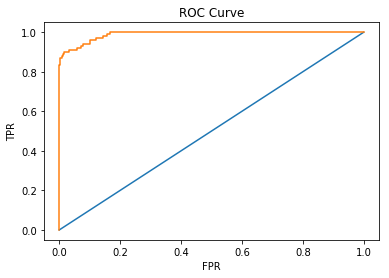

<Figure size 432x288 with 0 Axes>

In [8]:
generate_auc(X_train, y_train, X_test, y_test, baseline_model)

# Bayesian Optimization + Light GMB

In [9]:
import lightgbm as lgb
from skopt import gp_minimize

def objective(params):
    learning_rate = 10. ** params[0]
    num_leaves = params[1]
    n_estimators = params[2]

    lgbm = lgb.LGBMClassifier(
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=8,
        n_estimators=n_estimators,
        verbose=0,
    )

    return -np.mean(cross_val_score(lgbm, X_train, y_train, cv=10, scoring='f1'))

search_space = [(-5.0, 0.0), (2, 100), (2, 300)]

r = gp_minimize(objective, search_space, n_calls=20, random_state=42, n_jobs=-1, verbose=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/

[-1.6698105254120374, 100, 300]

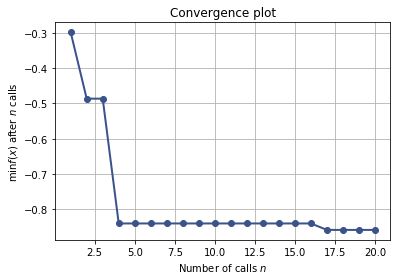

In [10]:
from skopt.plots import plot_convergence

plot_convergence(r)
best_params = r.x
best_params

In [11]:
final_lgbm = lgb.LGBMClassifier(num_leaves=best_params[1],
                        learning_rate= 10 ** best_params[0],
                        n_estimators=best_params[2],
                        verbose=1)

In [12]:
final_model_test(X_train, y_train, X_test, y_test, final_lgbm)

Model Results
[[56860     4]
 [   22    76]]


Accuracy:              0.9995
Precision:              0.9500
Recall:                 0.7755
F1 Score:               0.8539


AUC:               0.9733


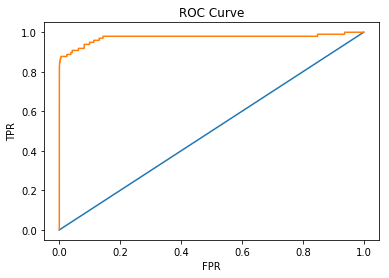

<Figure size 432x288 with 0 Axes>

In [13]:
generate_auc(X_train, y_train, X_test, y_test, final_lgbm)

# Autoencoder Experiment

In [14]:
#Split data by class for training/testing
X_autoencoder = df.query('Class == 0').drop(['Class'],axis=1)
Y_fraud = df.query('Class == 1').drop(['Class'],axis=1)

X_train_autoencoder = X_autoencoder.sample(frac=0.8,random_state=42)
X_test_autoencoder = X_autoencoder.drop(X_train_autoencoder.index)

In [15]:
from sklearn.metrics import mean_squared_error

#Renaming mse function to be consistent with literature
reconstruction_loss = mean_squared_error


In [16]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential

epochs = 100
batch_size = 64
input_dim = X_train_autoencoder.shape[1] #num of columns, 30
encoding_dim = 16
hidden_dim = 8 
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='adam')

autoencoder.fit(X_train_autoencoder, X_train_autoencoder, epochs=epochs, validation_data=(X_test_autoencoder, X_test_autoencoder))



Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Train on 227452 samples, validate on 56863 samples
Epoch 1/100
227452/227452 [==============================] - 10s 44us/step - loss: 0.6866 - val_loss: 0.6417
Epoch 2/100
227452/227452 [==============================] - 10s 46us/step - loss: 0.6286 - val_loss: 0.6276
Epoch 3/100
227452/227452 [==============================] - 10s 44us/step - loss: 0.6200 - val_loss: 0.6227
Epoch 4/100
227452/227452 [==============================] - 10s 44us/step - loss: 0.6162 - val_loss: 0.6201
Epoch 5/100
227452/227452 [==============================] - 16s 71us/step - loss: 0.6144 - val_loss: 0.6194
Epoch 6/100
227452/227452 [==============================] - 12s 51us/step - loss: 0.6132 - val_loss: 0.6168
Epoch 7/100
227452/227452 [==============================] - 11s 48us/step - loss: 0.6124 - val_loss: 0.6169
Epoch 8/100
227452/227452 [==============================] - 15s 66us/step - loss: 0.6117 - val_loss: 0.6163
Epoch 9/100
227452/227452 [==============================] - 11s 49us/step - 

227452/227452 [==============================] - 11s 47us/step - loss: 0.5983 - val_loss: 0.6050
Epoch 76/100
227452/227452 [==============================] - 11s 48us/step - loss: 0.5983 - val_loss: 0.6020
Epoch 77/100
227452/227452 [==============================] - 9s 38us/step - loss: 0.5983 - val_loss: 0.6023
Epoch 78/100
227452/227452 [==============================] - 9s 40us/step - loss: 0.5982 - val_loss: 0.6026
Epoch 79/100
227452/227452 [==============================] - 9s 37us/step - loss: 0.5982 - val_loss: 0.6022
Epoch 80/100
227452/227452 [==============================] - 8s 36us/step - loss: 0.5980 - val_loss: 0.6027
Epoch 81/100
227452/227452 [==============================] - 9s 40us/step - loss: 0.5981 - val_loss: 0.6019
Epoch 82/100
227452/227452 [==============================] - 9s 38us/step - loss: 0.5983 - val_loss: 0.6054
Epoch 83/100
227452/227452 [==============================] - 9s 40us/step - loss: 0.5982 - val_loss: 0.6023
Epoch 84/100
227452/227452 [==

In [17]:
def predict(trained_model, set_threshold, input_data):
    predicted_array = trained_model.predict(input_data)
    instance_rec_loss = reconstruction_loss(input_data, predicted_array)
    
    if set_threshold == -1:
        return instance_rec_loss
    
    elif instance_rec_loss >= set_threshold:
        return 1
    
    else:
        return 0

In [18]:
from scipy import stats

rec_loss_dist_nonfraud = [predict(autoencoder,-1,np.array(X_autoencoder.iloc[n:n+1,:])) for n in tqdm_notebook(range(len(X_autoencoder)))]
rec_loss_dist_fraud = [predict(autoencoder,-1,np.array(Y_fraud.iloc[n:n+1,:])) for n in tqdm_notebook(range(len(Y_fraud)))]


In [19]:
print("Descriptive Statistics of Reconstruction Loss (ALL DATA) \n")

nonfraud_stats = stats.describe(rec_loss_dist_nonfraud)
print("\nNon-Fraudulent Data Stats:\n", nonfraud_stats)
fraud_stats = stats.describe(rec_loss_dist_fraud)
print("\nFraudulent Data Stats:\n", fraud_stats)


Descriptive Statistics of Reconstruction Loss (ALL DATA) 


Non-Fraudulent Data Stats:
 DescribeResult(nobs=284315, minmax=(0.017202105374164188, 1787.0585972667238), mean=0.5987394223017254, variance=22.108229560998556, skewness=211.67287641084738, kurtosis=74581.84732999637)

Fraudulent Data Stats:
 DescribeResult(nobs=492, minmax=(0.0911002002552423, 257.2054944288735), mean=24.057531492917363, variance=1213.7109917497041, skewness=2.4349316639785283, kurtosis=8.171171130440706)


In [20]:
#Initial threshold set to midpoint of the two means
threshold = nonfraud_stats.mean + abs(fraud_stats.mean - nonfraud_stats.mean)/2


In [21]:
y_pred = []

for index, row in tqdm_notebook(X_test.iterrows()):
     y_pred.append(predict(autoencoder, threshold, np.array([row.values])))
        

In [22]:
y_score = []

for index, row in tqdm_notebook(X_test.iterrows()):
     y_score.append(predict(autoencoder, -1, np.array([row.values])))

In [23]:
y_true = y_test
conf = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf.ravel()

print("Model Results")
print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n Performance')
print ("Accuracy:              %0.4f" % accuracy_score(y_pred,y_true))
print ("Precision:              %0.4f" % precision)
print ("Recall:                 %0.4f"% recall)
print ("F1 Score:               %0.4f"% f1_score)

Model Results
[[56650   214]
 [   62    36]]

 Performance
Accuracy:              0.9952
Precision:              0.1440
Recall:                 0.3673
F1 Score:               0.2069


In [24]:
len(y_score), len(X_test)

(56962, 56962)

AUC:               0.9494


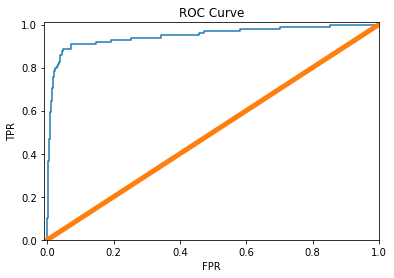

In [25]:
#AUC for autoencoder
FPR, TPR, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(FPR, TPR,)
print ("AUC:               %0.4f"% roc_auc)

plt.plot(FPR, TPR)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

## To Do

- Need to optimize neural network aka hyperparameter search
- Generate PR curve functions